In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


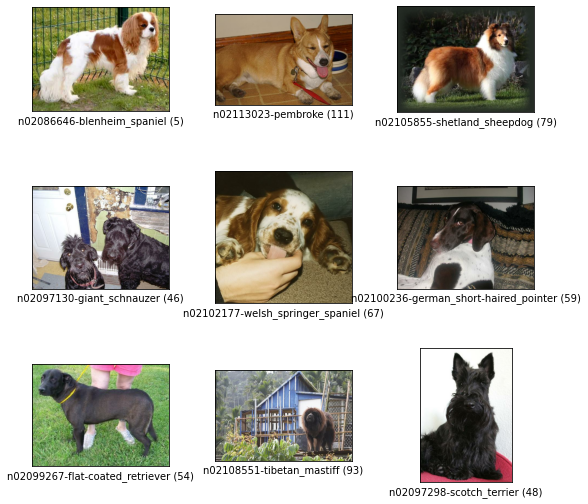

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

fig = tfds.show_examples(ds_info, ds_train)

In [3]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [4]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [5]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

In [7]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [8]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [9]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [10]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 115s 153ms/step - loss: 2.2201 - accuracy: 0.4468 - val_loss: 3.2087 - val_accuracy: 0.2294
Epoch 2/20
750/750 [==============================] - 117s 155ms/step - loss: 0.8011 - accuracy: 0.7753 - val_loss: 1.1114 - val_accuracy: 0.6748
Epoch 3/20
750/750 [==============================] - 116s 155ms/step - loss: 0.3205 - accuracy: 0.9227 - val_loss: 1.0652 - val_accuracy: 0.6933
Epoch 4/20
750/750 [==============================] - 117s 155ms/step - loss: 0.1215 - accuracy: 0.9787 - val_loss: 0.9722 - val_accuracy: 0.7222
Epoch 5/20
750/750 [==============================] - 117s 156ms/step - loss: 0.0453 - accuracy: 0.9963 - val_loss: 0.9340 - val_accuracy: 0.7364
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0294 - accuracy: 0.9979 - val_loss: 0.9490 - val_accuracy: 0.7337
Epoch 7/20
750/750 [==============================] - 116s 154ms/step - loss: 0.0235 - accuracy: 0.9982 - val_loss: 0.9540 -

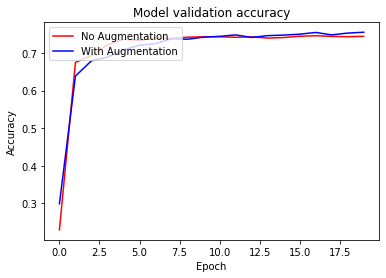

In [11]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

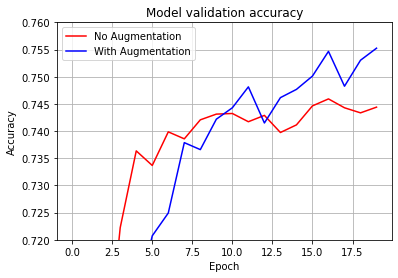

In [12]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

# (1) Cutmix Augmentation
##### CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법

### 1) 이미지 섞기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [2]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

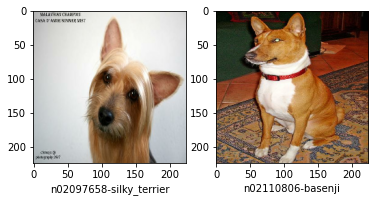

In [3]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
index_to_label = ds_info.features["label"].names
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('{}'.format(index_to_label[label_a]))
plt.imshow(image_a)

ax2=plt.subplot(1,2,2)
ax2.set_xlabel('{}'.format(index_to_label[label_b]))
plt.imshow(image_b)


In [4]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(45, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(129, shape=(), dtype=int32)


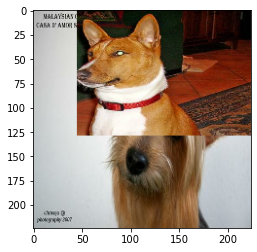

In [5]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 2) 라벨 섞기

In [6]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.5397999, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [7]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        random_idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[random_idx]
        xa, ya, xb, yb = get_clip_box(image_a,image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label[i], label[random_idx], xa, ya, xb, yb))
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# (2) Mixup Augmentation
##### 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주는 방법

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.5397999 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4602001 0.        0.        0.
 0.        0.        0.      

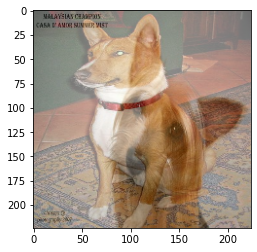

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [9]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        random_idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[random_idx]
        label_b = label[random_idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def onehot(image,label,classes=120):
    return image,tf.one_hot(label,classes)

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 순서 주의
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## cutmix
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## cut mix의 성능을 알아보기 위해 with_aug는 둘다 적용
ds_train_no_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True,with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [12]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_cutmix = resnet50.fit(
    ds_train_no_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 112s 149ms/step - loss: 2.2358 - accuracy: 0.4353 - val_loss: 2.8682 - val_accuracy: 0.2706
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.9515 - accuracy: 0.7249 - val_loss: 1.2809 - val_accuracy: 0.6381
Epoch 3/20
750/750 [==============================] - 111s 147ms/step - loss: 0.5405 - accuracy: 0.8536 - val_loss: 1.0745 - val_accuracy: 0.6918
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.2752 - accuracy: 0.9329 - val_loss: 1.0242 - val_accuracy: 0.7072
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 0.1777 - accuracy: 0.9617 - val_loss: 1.0460 - val_accuracy: 0.7097
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 0.1184 - accuracy: 0.9771 - val_loss: 1.0564 - val_accuracy: 0.7119
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0884 - accuracy: 0.9847 - val_loss: 1.1024 -

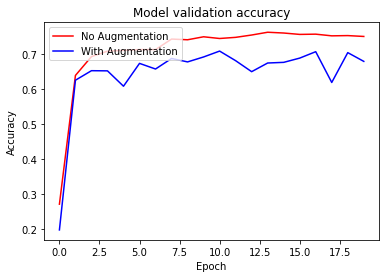

In [14]:
plt.plot(history_resnet50_no_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [17]:

## only cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])


ds_train_onlycutmix = apply_normalize_on_dataset(ds_train, with_aug=False,with_cutmix=True)

In [21]:
## only cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

ds_train_onlymixup = apply_normalize_on_dataset(ds_train, with_aug=False,with_mixup=True)

In [22]:
tf.random.set_seed(2020)
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_onlymixup = mixup_resnet50.fit(
    ds_train_onlymixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



Epoch 1/20
750/750 [==============================] - 120s 159ms/step - loss: 3.7683 - accuracy: 0.2343 - val_loss: 2.0481 - val_accuracy: 0.4525
Epoch 2/20
750/750 [==============================] - 117s 156ms/step - loss: 2.8859 - accuracy: 0.4761 - val_loss: 1.3995 - val_accuracy: 0.6059
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 2.6196 - accuracy: 0.5656 - val_loss: 1.4438 - val_accuracy: 0.6109
Epoch 4/20
750/750 [==============================] - 121s 161ms/step - loss: 2.4226 - accuracy: 0.6431 - val_loss: 1.5558 - val_accuracy: 0.5917
Epoch 5/20
750/750 [==============================] - 121s 161ms/step - loss: 2.2975 - accuracy: 0.6966 - val_loss: 1.2984 - val_accuracy: 0.6490
Epoch 6/20
750/750 [==============================] - 120s 160ms/step - loss: 2.1765 - accuracy: 0.7347 - val_loss: 1.1885 - val_accuracy: 0.6728
Epoch 7/20
750/750 [==============================] - 120s 160ms/step - loss: 2.0851 - accuracy: 0.7703 - val_loss: 1.2135 -

In [18]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_onlycutmix = cutmix_resnet50.fit(
    ds_train_onlycutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
# 아래 첫 20 epoch는 잘못 작성된 mixup 코드로 돌렸고 두번째 20 epoch가 cutmix에 대한 log

Epoch 1/20
750/750 [==============================] - 118s 157ms/step - loss: 0.5250 - accuracy: 0.9340 - val_loss: 32.4227 - val_accuracy: 0.0064
Epoch 2/20
750/750 [==============================] - 116s 155ms/step - loss: 0.4989 - accuracy: 0.9781 - val_loss: 12.9933 - val_accuracy: 0.0047
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 0.5031 - accuracy: 0.9771 - val_loss: 13.6439 - val_accuracy: 0.0050
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 0.5002 - accuracy: 0.9781 - val_loss: 13.6461 - val_accuracy: 0.0047
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 0.4975 - accuracy: 0.9837 - val_loss: 13.9272 - val_accuracy: 0.0048
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 0.5020 - accuracy: 0.9839 - val_loss: 14.1011 - val_accuracy: 0.0048
Epoch 7/20
750/750 [==============================] - 114s 152ms/step - loss: 0.4979 - accuracy: 0.9870 - val_loss: 14

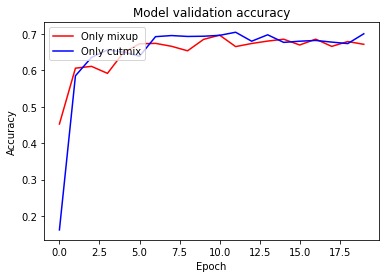

In [23]:
plt.plot(history_resnet50_onlymixup.history['val_accuracy'], 'r')
plt.plot(history_resnet50_onlycutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Only mixup', 'Only cutmix'], loc='upper left')
plt.show()

# mixup, cutmix 수정
원본 데이터 74, augmentaion을 진행했을 때 75, mixup 67, cutmix 70 원본 데이터에 대한 해석은 overfitting이 빠르게 일어난다로 해석을 해도 될 것 같다.

다만 mixup과 cutmix가 현재 매우 낮다. 두 코드 모두 원본 데이터에 대한 train을 하지 않기 때문에 1:1 비율로 원본과 mixup 혹은 cutmix를 사용하도록 코드를 변경했다(원래 올바른 변경은 random함수를 써서 하는게 맞다고 생각한다, 여기서는 빠르게 구현하기 위해 단순히 원본을 추가 입력했다).

In [11]:
def cutmix(image, label, prob = 1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        random_idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[random_idx]
        xa, ya, xb, yb = get_clip_box(image_a,image_b)
        if len(label[i].shape)==0:
            label_a = tf.one_hot(label[i], num_classes)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label[i], label[random_idx], xa, ya, xb, yb))
        mixed_imgs.append(image_a)
        mixed_labels.append(label_a)
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size*2, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size*2, num_classes))
    return mixed_imgs, mixed_labels


def mixup(image, label, prob = 1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = tf.one_hot(label[i], num_classes)
        random_idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[random_idx]
        label_b = tf.one_hot(label[random_idx], num_classes)
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        mixed_imgs.append(image_a)
        mixed_labels.append(label_a)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size*2, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size*2, num_classes))
    return mixed_imgs, mixed_labels

In [13]:

## only cutmix
cutmix_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])


ds_train_onlycutmix2 = apply_normalize_on_dataset(ds_train, with_aug=False,with_cutmix=True)

## only cutmix
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

ds_train_onlymixup2 = apply_normalize_on_dataset(ds_train, with_aug=False,with_mixup=True)

In [14]:
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

tf.random.set_seed(2020)
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_onlymixup2 = mixup_resnet50.fit(
    ds_train_onlymixup2,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

cutmix_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_onlycutmix2 = cutmix_resnet50_2.fit(
    ds_train_onlycutmix2, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 120s 160ms/step - loss: 3.3641 - accuracy: 0.2508 - val_loss: 4.6875 - val_accuracy: 0.0710
Epoch 2/20
750/750 [==============================] - 119s 159ms/step - loss: 2.4118 - accuracy: 0.4556 - val_loss: 1.6797 - val_accuracy: 0.5346
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 1.8545 - accuracy: 0.6255 - val_loss: 1.7588 - val_accuracy: 0.5500
Epoch 4/20
750/750 [==============================] - 120s 161ms/step - loss: 1.5640 - accuracy: 0.7205 - val_loss: 1.3848 - val_accuracy: 0.6166
Epoch 5/20
750/750 [==============================] - 120s 159ms/step - loss: 1.3754 - accuracy: 0.7945 - val_loss: 1.3361 - val_accuracy: 0.6340
Epoch 6/20
750/750 [==============================] - 121s 161ms/step - loss: 1.1623 - accuracy: 0.8606 - val_loss: 1.1513 - val_accuracy: 0.6872
Epoch 7/20
750/750 [==============================] - 120s 160ms/step - loss: 1.1780 - accuracy: 0.8481 - val_loss: 1.2090 -

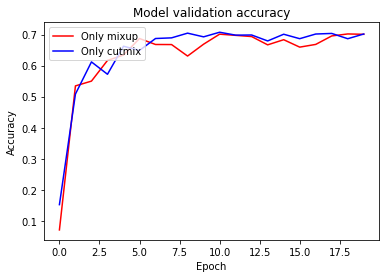

In [15]:
plt.plot(history_resnet50_onlymixup2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_onlycutmix2.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Only mixup', 'Only cutmix'], loc='upper left')
plt.show()

둘다 기존 augmentation보다 성능이 좋은지 잘 모르겠다. epoch를 더 크게 설정해 확인을 하거나 augmentation에 추가되었을 때의 성능을 확인하는 것, 이렇게 2가지가 떠오르는데 train에 시간이 너무 많이 소요된다.